<a href="https://colab.research.google.com/github/FalaahArifKhan/RAI-summer-stability/blob/main/EDA/EDA_AL_2016.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [466]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, pairwise_distances, DistanceMetric

from collections import defaultdict
from sys import getsizeof
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import statsmodels.api as sm
from copy import deepcopy

import sys
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint


import warnings
warnings.filterwarnings('ignore')

In [467]:
from IPython.display import clear_output 
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment
    clear_output()

## Data distribution among states and years

In [432]:
STATES = [
    'AL', 'AK', 'AZ', 'AR', 'CA',
    'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA',
    'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO',
    'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH',
    'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT',
    'VA', 'WA', 'WV', 'WI', 'WY'
]

SURVEY = ['person', 'household']
MIN_YEAR, MAX_YEAR = 2014, 2018
YEARS = list(range(MIN_YEAR, MAX_YEAR + 1))

In [ ]:
data = defaultdict(list)
for year in YEARS:
    data_source = ACSDataSource(
    survey_year=str(year),
    horizon='1-Year',
    survey='person'
)
    print(year)
    for state in STATES:
        acs_data = data_source.get_data(states=[state], download=False)
        features, label, group = ACSEmployment.df_to_numpy(acs_data)
        assert features.shape[0] == label.shape[0] == group.shape[0]
        data[year].append(label.shape[0])
df = pd.DataFrame(data)
df['state'] = STATES

In [ ]:
for year in YEARS:
    fig = px.bar(df, x='state', y=year)
    fig.update_layout(yaxis=dict(title='num observations'), title=f'Distribution by {year}', title_x=.5)
    fig.show()

## Data profiling

In [468]:
data_source = ACSDataSource(
    survey_year='2016',
    horizon='1-Year',
    survey='person'
)
acs_data = data_source.get_data(states=['AL'], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
features.shape, label.shape, group.shape

((47659, 16), (47659,), (47659,))

In [469]:
X_full = pd.DataFrame(features, columns=ACSEmployment.features).fillna(0).drop(['RELP'], axis=1)
y_full = pd.DataFrame(label)
y_full.rename(columns={0: ACSEmployment.target}, inplace=True)
getsizeof(X_full)

5719240

#### Describing numerical column from the dataset

In [470]:
significant = ['AGEP', 'SCHL', 'MAR', 'DIS', 'ESP', 'CIT', 'MIG', 'ANC', 
              'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX']
numerical = ['AGEP']
almost_numerical = numerical + ['SCHL', ACSEmployment.target]
categorical = [col for col in X_full.columns if col not in numerical and col != 'RAC1P']
X_full[numerical].describe()

,AGEP
count,47659.000000
mean,42.542752
std,23.843445
min,0.000000
25%,22.000000
50%,44.000000
75%,62.000000
max,93.000000


#### Converting the dataset to right datatypes

In [471]:
for column in categorical:
    X_full[column] = pd.to_numeric(X_full[column], downcast='integer')
getsizeof(X_full)

1382271

#### Dealing with categorical variables with onehot encoding

In [472]:
X_full.head(3)

,AGEP,SCHL,MAR,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P
0,84.0,19,1,2,0,1,1,4,1,1,2,2,2,2,1.0
1,84.0,21,1,2,0,1,1,4,1,1,2,2,2,1,1.0
2,78.0,19,3,2,0,1,1,4,4,1,2,2,2,2,1.0


In [473]:
full = pd.concat([X_full, y_full], axis=1)
getsizeof(full)

1429930

#### Check for Nan's

In [474]:
full.isna().any().any()

False

In [475]:
full.groupby('SEX')[almost_numerical].mean()

,AGEP,SCHL,ESR
SEX,,,
1,40.938719,15.025926,0.431801
2,44.027719,15.633304,0.377566


In [476]:
full.groupby('RAC1P')[almost_numerical].mean()

,AGEP,SCHL,ESR
RAC1P,,,
1.0,43.854122,15.639179,0.421241
2.0,40.218830,14.741797,0.353172
3.0,41.000000,15.464865,0.421622
5.0,33.260870,12.043478,0.195652
6.0,37.143369,15.636201,0.451613
7.0,46.944444,15.500000,0.444444
8.0,27.783599,11.093394,0.410023
9.0,29.068120,12.707084,0.292916


In [477]:
full.drop('RAC1P', axis=1, inplace=True)
X_full.drop('RAC1P', axis=1, inplace=True)

In [478]:
X_full_dummies = pd.get_dummies(X_full, drop_first=True, columns=categorical)
full_dummies = pd.concat([X_full_dummies, y_full], axis=1)
getsizeof(full_dummies)

3145654

## Correlation matrix and distributions

In [479]:
fig = px.imshow(full.corr())
fig.show()

In [480]:
counter = 0
fig = make_subplots(rows=1, cols=3, subplot_titles=almost_numerical)
for column in almost_numerical:
    col = counter % 3 + 1
    counter += 1
    fig.add_trace(go.Histogram(x=full[column]), row=1, col=col)
fig.update_layout(showlegend=False)
fig.show()

Why is there so many 93 year old?

## Baseline model

In this subsection the following models were tested and parameter-tuned:

1. Naive Bayes Classifier
2. Support Vector Machine
3. Logistic Regression
4. Random Forest Classifier
5. Decision Tree Classifier
6. XGBoost Classifier

In [411]:
SEED = 0
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    X_full_dummies, y_full, group, test_size=.2, random_state=SEED)

In [377]:
n_folds = 3
samples_per_fold = len(y_test)
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [378]:
config_models = [
    {
        'model_name': 'GaussianNB',
        'model': GaussianNB(),
        'params': {
            'var_smoothing': [1e-9, 1e-5]
        }
    },
    {
        'model_name': 'SVC',
        'model': SVC(random_state=SEED),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        }
    },
    {
        'model_name': 'LogisticRegression',
        'model': LogisticRegression(random_state=SEED),
        'params': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'fit_intercept': [True, False],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'max_iter':  range(50, 251, 50),
        }
    },
    {
        'model_name': 'RandomForestClassifier',
        'model': RandomForestClassifier(random_state=SEED),
        'params': {
            "bootstrap": [True, False],
            "max_depth": [3, 4, 6, 10],
            "n_estimators": [5 * i for i in range(1, 7)],
            "max_features": [0.6]
        }
    },
    {
        'model_name': 'DecisionTreeClassifier',
        'model': DecisionTreeClassifier(random_state=SEED),
        'params': {
            "max_depth": [2, 3, 4, 6, 10],
            "min_samples_split": [2, 6],
            "min_samples_leaf": [1, 2, 4],
            "max_features": [0.6, 'sqrt'],
            "criterion": ["gini", "entropy"]
        }
    },
    # For XGBoost parameters tuning we used this article --
    # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    {
        'model_name': 'XGBClassifier',
        'model': XGBClassifier(random_state=SEED),
        'params': {
            'learning_rate': [0.1, 0.01],
            'n_estimators': [100, 200],
            'max_depth': range(3, 10, 2),
            'objective':  ['binary:logistic'],
        }
    }
]

In [379]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation
    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)

In [380]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyper-parameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.values.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_, \
           grid_search.cv_results_["mean_test_F1_Score"][best_index], \
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index], \
           grid_search.best_params_

In [381]:
def test_evaluation(cur_best_model, model_name, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title, show_plots, debug_mode):
    """
    Evaluate model on test set.
    :return: F1 score, accuracy and predicted values, which we use to visualisations for model comparison later.
    """
    cur_best_model.fit(cur_x_train, cur_y_train.values.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)
    test_f1_score = f1_score(cur_y_test, cur_model_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, cur_model_pred)

    if debug_mode:
        print("#" * 20, f' {dataset_title} ', "#" * 20)
        print('Test model: ', model_name)
        print('Test model parameters:')
        pprint(cur_best_params)

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        if show_plots:
            # plot the confusion matrix
            cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Employed", "Not Employed"])
            disp.plot()
            plt.show()
    return test_f1_score, test_accuracy, cur_model_pred

In [382]:
def test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                   X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyper-parameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    best_f1_score = -np.Inf
    best_accuracy = -np.Inf
    best_model_pred = []
    best_model_name = 'No model'
    best_params = None
    idx = 0
    # find the best model among defined in config_models
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                           X_train, y_train, model_config['params'],
                                                                           n_folds, samples_per_fold)
        print(f'Tuning for {model_config["model_name"]} is finished')

        test_f1_score, test_accuracy, cur_model_pred = test_evaluation(cur_model, model_config['model_name'], cur_params,
                                                                       X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)
        # save test results of each model in dataframe
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               test_f1_score,
                               test_accuracy,
                               cur_params]
        idx += 1

        if test_f1_score > best_f1_score:
            best_f1_score = test_f1_score
            best_accuracy = test_accuracy
            best_model_name = model_config['model_name']
            best_params = cur_params
            best_model_pred = cur_model_pred

    # append results of best model in best_results_df
    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     best_model_pred]

    return results_df

Tuning for GaussianNB is finished
####################  Folktables [AL]  ####################
Test model:  GaussianNB
Test model parameters:
{'var_smoothing': 1e-05}

              precision    recall  f1-score   support

       False      0.919     0.541     0.681      5675
        True      0.579     0.930     0.714      3857

    accuracy                          0.698      9532
   macro avg      0.749     0.735     0.697      9532
weighted avg      0.781     0.698     0.694      9532



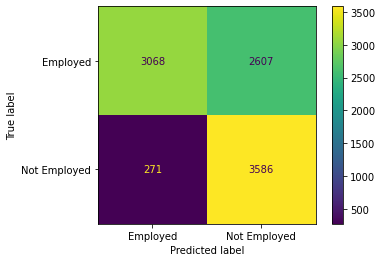

Tuning for SVC is finished
####################  Folktables [AL]  ####################
Test model:  SVC
Test model parameters:
{'kernel': 'linear'}

              precision    recall  f1-score   support

       False      0.852     0.774     0.811      5675
        True      0.706     0.802     0.751      3857

    accuracy                          0.785      9532
   macro avg      0.779     0.788     0.781      9532
weighted avg      0.793     0.785     0.787      9532



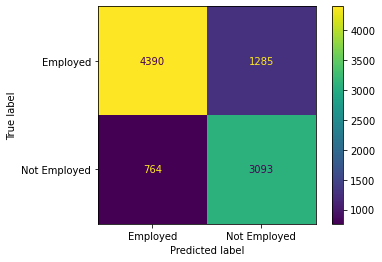

Tuning for LogisticRegression is finished
####################  Folktables [AL]  ####################
Test model:  LogisticRegression
Test model parameters:
{'fit_intercept': False,
 'max_iter': 50,
 'penalty': 'none',
 'solver': 'newton-cg'}

              precision    recall  f1-score   support

       False      0.835     0.790     0.811      5675
        True      0.713     0.770     0.740      3857

    accuracy                          0.782      9532
   macro avg      0.774     0.780     0.776      9532
weighted avg      0.785     0.782     0.783      9532



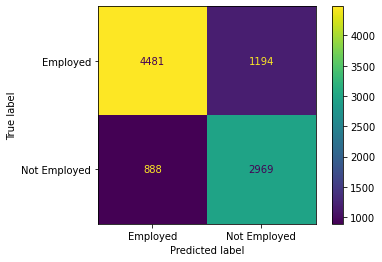

Tuning for RandomForestClassifier is finished
####################  Folktables [AL]  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.6, 'n_estimators': 25}

              precision    recall  f1-score   support

       False      0.881     0.791     0.834      5675
        True      0.733     0.843     0.784      3857

    accuracy                          0.812      9532
   macro avg      0.807     0.817     0.809      9532
weighted avg      0.821     0.812     0.814      9532



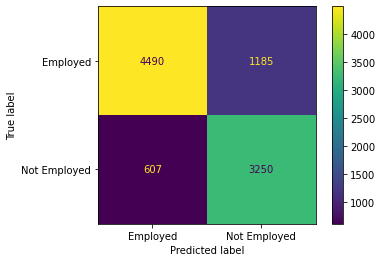

Tuning for DecisionTreeClassifier is finished
####################  Folktables [AL]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.6,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

              precision    recall  f1-score   support

       False      0.884     0.780     0.828      5675
        True      0.724     0.849     0.781      3857

    accuracy                          0.808      9532
   macro avg      0.804     0.814     0.805      9532
weighted avg      0.819     0.808     0.809      9532



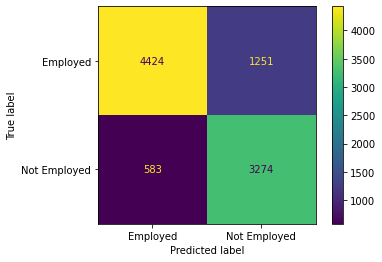

Tuning for XGBClassifier is finished
####################  Folktables [AL]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 100,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

       False      0.868     0.816     0.841      5675
        True      0.752     0.817     0.783      3857

    accuracy                          0.817      9532
   macro avg      0.810     0.817     0.812      9532
weighted avg      0.821     0.817     0.818      9532



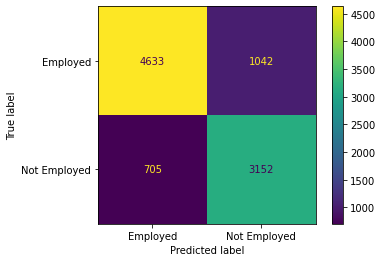

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [AL],GaussianNB,0.697175,0.698070,{'var_smoothing': 1e-05}
1,Folktables [AL],SVC,0.780985,0.785040,{'kernel': 'linear'}
2,Folktables [AL],LogisticRegression,0.775940,0.781578,"{'fit_intercept': False, 'max_iter': 50, 'pena..."
3,Folktables [AL],RandomForestClassifier,0.808765,0.812002,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
4,Folktables [AL],DecisionTreeClassifier,0.804754,0.807595,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
5,Folktables [AL],XGBClassifier,0.812189,0.816723,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."


In [383]:
ML_results_df = test_ML_models(best_results_df, config_models, n_folds, samples_per_fold,
                               X_train, y_train, X_test, y_test, "Folktables [AL]", show_plots=True, debug_mode=True)
ML_results_df

In [447]:
best_params = ML_results_df.loc[5, 'Model_Best_Params']
model = XGBClassifier(max_depth=best_params['max_depth']).fit(X_train, y_train)

Comparing true positives rate for two groups of people is one of the fairness metrics. Ideally, this metric should not depend on gender or race (it should equal 0).

In [448]:
y_pred = model.predict(X_test).reshape((-1, 1))
group_test = group_test.reshape((-1, 1))

white_tpr = np.mean(y_pred[(y_test == 1) & (group_test == 1)])
black_tpr = np.mean(y_pred[(y_test == 1) & (group_test == 2)])

white_tpr - black_tpr

0.0010788895336495408

## Questions and ideas for further research:

1. Is it worth it to combine some states together?
2. Why the correlation between target and age is sometimes negative, sometimes positive?
3. Maybe use synthetic minority oversampling technique (SMOTE) to populate some groups of people
No code, useful plots. Provide ideas. Write the report together with Denys. Compare our model approaches.
4. Use "Jenga" made by Sebastian